In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, TargetEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
#Тестирование разных кластеров на успешность разделения выборки по accident_risk
def findBestCluster(data, cluster_model, threshold):
    X = data.drop('accident_risk', axis=1)
    y = data['accident_risk']

    columns_combinations = []
    for next_col in X.columns[:4]:
        append_combinations = []
        for prev_combination in columns_combinations:
            next_combination = list(prev_combination)
            next_combination.append(next_col)
            append_combinations.append(next_combination)
        columns_combinations.extend(append_combinations)
        columns_combinations.append([next_col])
    columns_combinations = list(filter(lambda x: len(x)>1, columns_combinations))

    result = (float('-inf'), [])
    for cluster_columns in columns_combinations:
        cluster_data = pd.get_dummies(X[cluster_columns])
        cluster_model.fit(cluster_data)
        cluster_label = cluster_model.labels_.astype(bool)
        cluster_accuracy = np.sum((y>threshold)==cluster_label) / y.shape[0]
        result = max(result, (cluster_accuracy, cluster_columns))
    return result

#Обучение модели
def train_model(model, df):
    X = df.drop('accident_risk', axis=1)
    y = df['accident_risk'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print('Параметры модели')
    print(f'Параметры: {model.best_params_}')
    print(f'Ошибка модели = {root_mean_squared_error(y_test, y_predict)}')

#
def GridSearch(df_train_origin, best_params, params_bias):
    part_perc = 0.5 
    parts_amount = 4
    params_bias = {param: }
    while part_perc <= 1:
        df_train_part = df_train_origin.iloc[np.random.choice(list(range(df_train_origin.shape[0])),
                                                              size=int(df_train_origin.shape[0]*part_perc),
                                                              replace=False)]
        catboost_model = CatBoostRegressor(learning_rate=0.1, 
                                           cat_features=['road_type','lighting','weather','time_of_day'],
                                           verbose=0)
        pipe_model = Pipeline([('model', catboost_model)])
        grid_params = {param: list(range(val-parts_amount*params_bias[param], val+parts_amount*b[param]+1, b[param])) 
                       for param, val in best_params.items()}
        grid_model = GridSearchCV(pipe_model, grid_params, scoring='neg_root_mean_squared_error', cv=5, verbose=2)
        train_model(grid_model, df_training)
        best_params = grid_model.best_params_
        part_perc += 0.1

In [12]:
a = {'iterations': 500, 
     'depth': 7}
b = {'iterations': 100, 
     'depth': 3}
parts_amount = 2

In [13]:
{param: list(range(val-parts_amount*b[param], val+parts_amount*b[param]+1, b[param])) for param, val in a.items()}

{'iterations': [300, 400, 500, 600, 700], 'depth': [1, 4, 7, 10, 13]}

In [5]:
np.linspace(1, 3, 5, dtype=np.int64)[::-1]

array([3, 2, 2, 1, 1])

In [3]:
#Загрузка данных
df_train_origin = pd.read_csv('train.csv', index_col='id')
df_test_origin = pd.read_csv('test.csv', index_col='id')
df_full = pd.concat([df_train_origin, df_test_origin], axis=0)

In [4]:
#Пропусков нет
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690339 entries, 0 to 690338
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               690339 non-null  object 
 1   num_lanes               690339 non-null  int64  
 2   curvature               690339 non-null  float64
 3   speed_limit             690339 non-null  int64  
 4   lighting                690339 non-null  object 
 5   weather                 690339 non-null  object 
 6   road_signs_present      690339 non-null  bool   
 7   public_road             690339 non-null  bool   
 8   time_of_day             690339 non-null  object 
 9   holiday                 690339 non-null  bool   
 10  school_season           690339 non-null  bool   
 11  num_reported_accidents  690339 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 55.3+ MB


In [5]:
#Признаки
#road_type - тип дороги (трасса, городская, деревенская)
#num_lanes - кол-ов полос на участке
#curvature - кривизна дороги (повороты): от 0(прямая) до 1(оч. извилистая)
#speed_limit - ограничение скорости (миль/час)
#lighting - освещение в моменте (дневной свет, ночь, тускло)
#weather - погода в моменте (ясно, дождливо, туман)
#road_signs_present - есть ли дорожные знаки на участке
#public_road - частная или общественная дорога
#time_of_day - время суток (утро, день, ночь)
#holiday - праздник ли в моменте
#school_season - школьная пора в моменте
#num_reported_accidents - кол-во подтвержденных проишествий на участке к моменту

<Axes: >

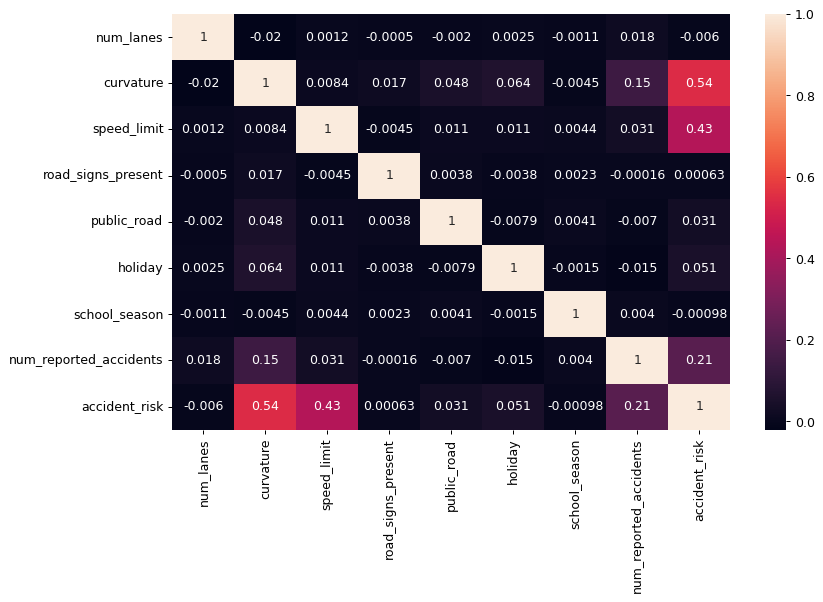

In [4]:
#Корреляция признаков (скоростное ограничение, извилистость и зарегистрированные происшествия)
df_corr = df_train_origin.drop(['road_type','lighting','weather','time_of_day'], axis=1).corr()
plt.figure(figsize=(10,6), dpi=90)
sns.heatmap(df_corr, annot=True)

In [ ]:
#I. Создание новых признаков:
#   1. На основе road_type создать признак Город (True, False) (НЕ УЛУЧШАЕТ)
#   2. Сделать num_lanes, speed_limit категориальным (НЕ УЛУЧШАЕТ)
#   3. Сделать Target Encoding на категориальные признаки (НЕ УЛУЧШАЕТ)
#   4. Сделать кластеры (НЕ УЛУЧШАЕТ)
#II. Ансамбль моделей
#   1. Для Обучения, Тестирования и Валидации использовать одни и те же данные для всех моделей
#   2. Обучить разные модели и записать их результаты в качестве признаков
#   3. Обучить финальную модель на этих признаках и target = accident_risk

<Axes: label='time_of_day', xlabel='time_of_day', ylabel='count'>

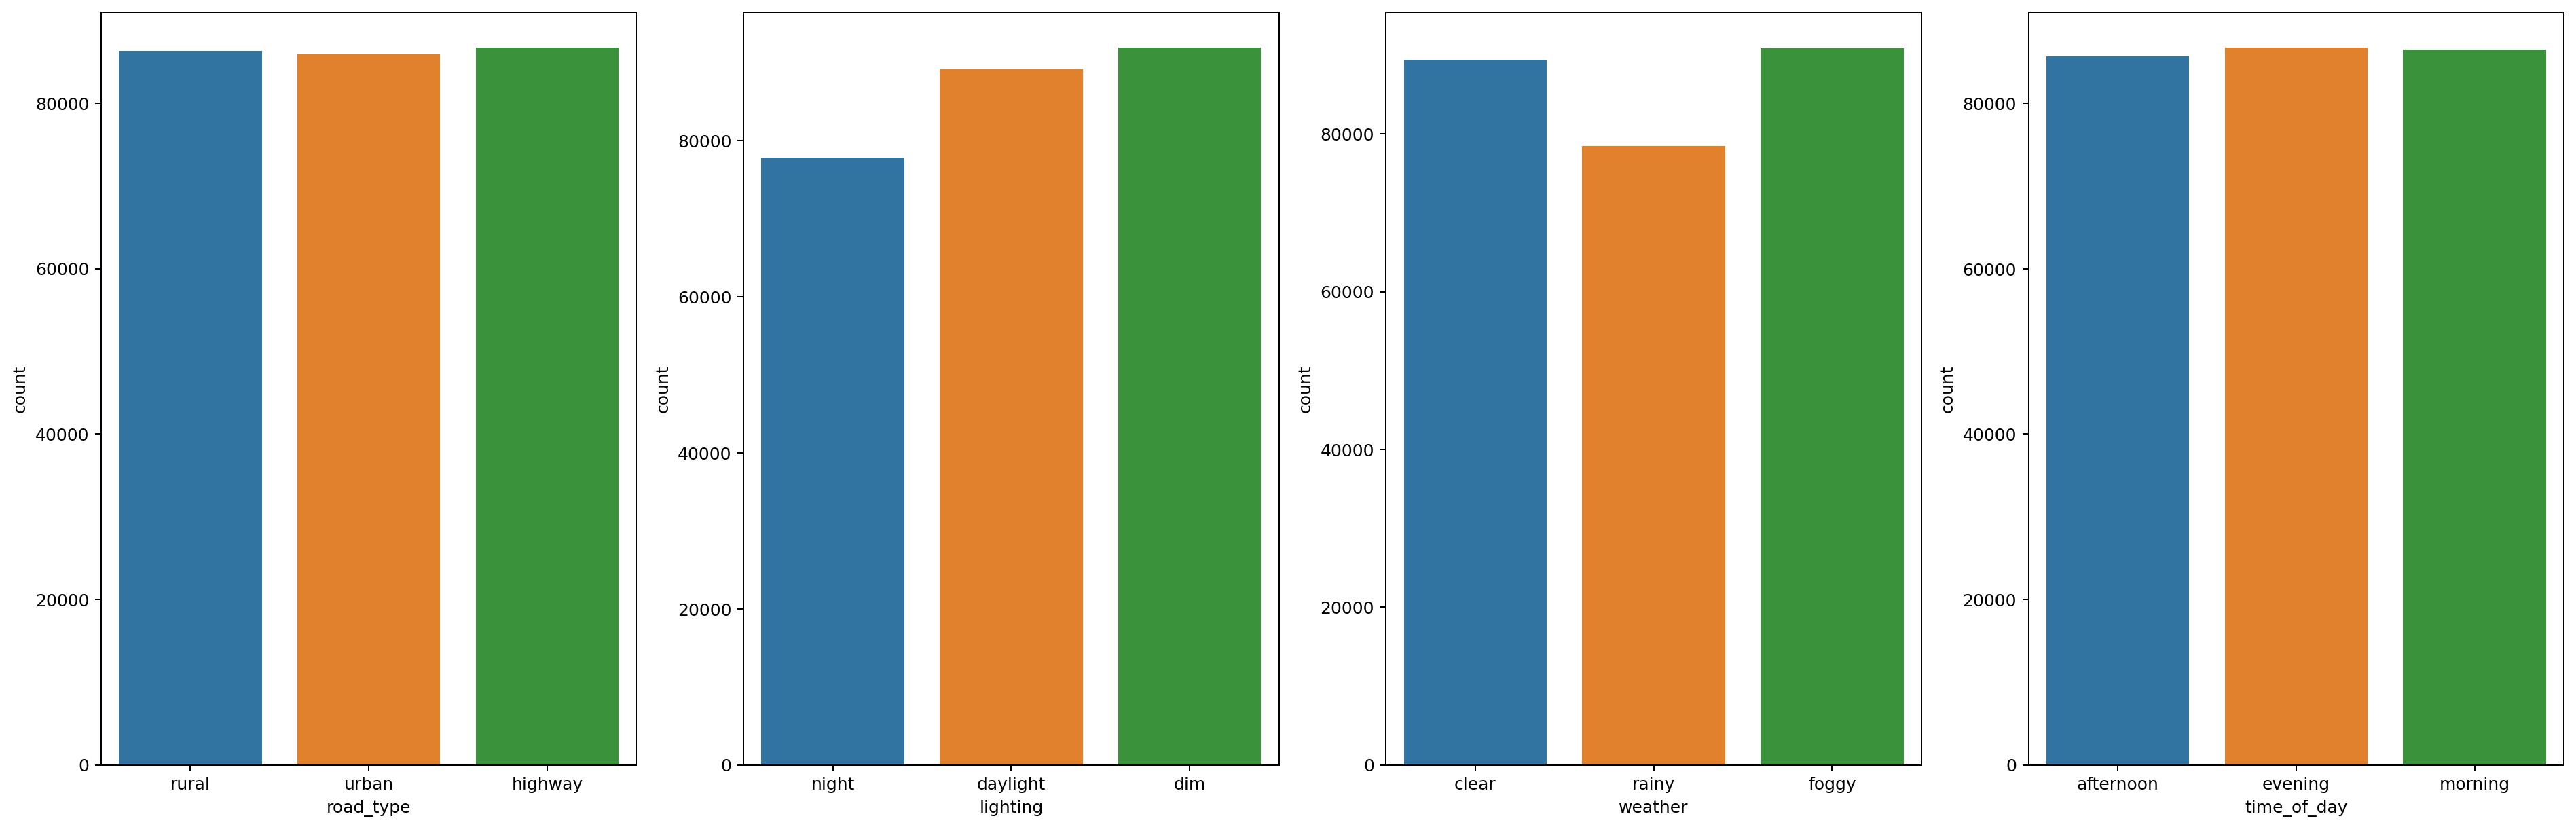

In [5]:
#Обучение на части выборки
part_perc = 0.5
df_train_part = df_train_origin.iloc[np.random.choice(list(range(df_train_origin.shape[0])),
                                                      size=int(df_train_origin.shape[0]*part_perc),
                                                      replace=False)]
fig, (ax_road_type, ax_lighting, ax_weather, ax_time_of_day) = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(26)
fig.set_figheight(8)
fig.set_dpi(180)
ax_road_type.set_label('road_type')
sns.countplot(df_train_part, x='road_type', hue='road_type', ax=ax_road_type)
ax_lighting.set_label('lighting')
sns.countplot(df_train_part, x='lighting', hue='lighting', ax=ax_lighting)
ax_weather.set_label('weather')
sns.countplot(df_train_part, x='weather', hue='weather', ax=ax_weather)
ax_time_of_day.set_label('time_of_day')
sns.countplot(df_train_part, x='time_of_day', hue='time_of_day', ax=ax_time_of_day)

In [22]:
#II. Будем обучать несколько моделей, результаты их работы используем как признаки для обучения Нейронной сети

In [86]:
#XGBoost
df_training = pd.get_dummies(df_train_origin)
xgboost_model = XGBRegressor()
pipe_model = Pipeline([('model', xgboost_model)])
grid_params = {'model__n_estimators': [405],
               'model__max_leaves': [17]}
grid_model = GridSearchCV(pipe_model, grid_params, scoring='neg_root_mean_squared_error', cv=5, verbose=2)
train_model(grid_model, df_training)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ......model__max_leaves=17, model__n_estimators=405; total time=   1.1s
[CV] END ......model__max_leaves=17, model__n_estimators=405; total time=   1.1s
[CV] END ......model__max_leaves=17, model__n_estimators=405; total time=   1.1s
[CV] END ......model__max_leaves=17, model__n_estimators=405; total time=   1.1s
[CV] END ......model__max_leaves=17, model__n_estimators=405; total time=   1.1s
Параметры модели
Кол-во деревьев: 405
Макс. глубина дерева: 17
Ошибка модели = 0.056281903258934694


In [6]:
#CatBoost
df_training = pd.DataFrame(df_train_part)
catboost_model = CatBoostRegressor(learning_rate=0.1, 
                                   cat_features=['road_type','lighting','weather','time_of_day'],
                                   verbose=0)
pipe_model = Pipeline([('model', catboost_model)])
grid_params = {'model__iterations': [400],
               'model__depth': [7]}
grid_model = GridSearchCV(pipe_model, grid_params, scoring='neg_root_mean_squared_error', cv=5, verbose=2)
train_model(grid_model, df_training)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..............model__depth=7, model__iterations=400; total time=  16.8s
[CV] END ..............model__depth=7, model__iterations=400; total time=  16.5s
[CV] END ..............model__depth=7, model__iterations=400; total time=  16.5s
[CV] END ..............model__depth=7, model__iterations=400; total time=  16.4s
[CV] END ..............model__depth=7, model__iterations=400; total time=  16.3s
Параметры модели
Параметры: {'model__depth': 7, 'model__iterations': 400}
Ошибка модели = 0.05639622947485164


In [14]:
grid_model.best_params_

{'model__depth': 7, 'model__iterations': 400}